In [1]:
# Handwritten Neural Network test: HandwrittenNN.ipynb
# Author: comtalyst

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Activation functions

## Sigmoid
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

def sigmoid_deriv(Z):
    '''
    (Coursera DL Notes, p. 8)
    '''
    D = sigmoid(Z)
    return D*(1 - D)

## ReLu
def relu(Z):
    A = np.maximum(0, Z)
    return A

def relu_deriv(Z):
    '''
    (Coursera DL Notes, p. 9)
    '''
    D = np.ones(Z.shape)
    D[Z <= 0] = 0
    return D

## Global interface
def activate(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid(Z)
    elif activation == "relu":
        return relu(Z)
    else:
        return Z

def activate_deriv(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid_deriv(Z)
    elif activation == "relu":
        return relu_deriv(Z)
    else:
        return 1

In [4]:
### Cost functions

def compute_loss(Y_, Y):
    '''
    (Coursera DL Notes, p. 4)
    (C1W4 , Block 5)
    ''' 
    loss = -(np.dot(Y, np.log(Y_).T) + np.dot(1-Y, np.log(1-Y_).T) )
    return loss

def compute_cost(Y_, Y):
    '''
    (C1W4, dnn_app_utils_v3.py)
    '''
    m = Y.shape[1]
    cost = (1/m) * compute_loss(Y_, Y)
    cost = np.squeeze(cost)                 # ensure correctness of shape
    return cost

In [5]:
### Initialization

def initialize_parameters(layers, random_b=False):
    L = len(layers)-1
    normal = 1           # to * random

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)
    for l in range(1, L+1):
        W[l] = np.random.randn(layers[l], layers[l-1]) * normal
        if random_b:    # mainly for gradient checking
            b[l] = np.random.randn(layers[l], 1) * normal
        else:
            b[l] = np.zeros((layers[l], 1))

    return W, b

In [6]:
### Forward propagation

# X: input in [features x samples]
# W: learnable parameters in [layer x n(l) x n(l-1)]
# b: bias parameters in [layer x n(l) x 1]
# activations: an arraylist of string, size of l, denotes preferred activation for each layer
#   example: {relu, relu, sidmoid} means relu in l = 1,2, sigmoid in l = 3
def forward_propagation(X, W, b, activations):
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    # initialize linear output
    '''
    This np.ndarray allow us to contruct an array with size initialized and can have any data type in it (from dtype=object)
    Therefore, we could use this to create histogram-like array for the uneven NN
    '''
    Z = np.ndarray(shape=[L+1], dtype=object)
    A = np.ndarray(shape=[L+1], dtype=object)
    
    A[0] = X                # to make it work properly when l = 1 
    
    # loop the layers 1 to L
    for l in range(1, L+1):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        A[l] = activate(Z[l], activations[l-1])     # note that activations[]'s index is behind the looper for the ease of user inputting

    return A, Z
        

In [7]:
### Backward Propagation 

def backward_propagation(X, Z, A, W, b, Y, activations):
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    dZ = np.ndarray(shape=Z.shape, dtype=object)
    dA = np.ndarray(shape=A.shape, dtype=object)
    dW = np.ndarray(shape=W.shape, dtype=object)
    db = np.ndarray(shape=b.shape, dtype=object)

    A[0] = X                # to make it work properly when l = 1 

    # base case
    dA[L] = -(np.divide(Y, A[L]) - np.divide(1-Y, 1-A[L]))
    '''
    Both of this method and "dZ[L] = A[L] - Y" method works without any differences
    (Coursera DL Notes, p. 10)
    '''

    # loop the layers L to 1
    for l in reversed(range(1, L+1)):
        dZ[l] = dA[l] * activate_deriv(Z[l], activations[l-1]) 
        dW[l] = (1/m)*np.dot(dZ[l], A[l-1].T)
        db[l] = (1/m)*np.sum(dZ[l], axis = 1, keepdims = True) 
        dA[l-1] = np.dot(W[l].T, dZ[l])
        
    return dW, db


In [8]:
### Update paremeters

def update_parameters(W, b, dW, db, learning_rate):
    L = len(W)-1
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    return W, b

In [9]:
### Train model

def train_model(X, Y, layers, activations, learning_rate, iterations):
    L = len(activations)
    
    # Initialize parameters
    W, b = initialize_parameters(layers)

    # Iterations
    for i in range(0, iterations):
        # Forward propagation
        A, Z = forward_propagation(X, W, b, activations)

        # Print the result
        PRINT_COUNT = 50        # number of lines to be printed (regardless of #iterations)
        if iterations < PRINT_COUNT or i%(iterations//PRINT_COUNT) == 0:
            print("Iteration " + str(i) + ": cost = " + str(compute_cost(A[L], Y)))
        
        # (Algorithmic customizable) Learning rate decay
        if i == 1000:
            learning_rate /= 1.2
        if i == 5000:
            learning_rate /= 3.25
        if i == 8500:
            learning_rate /= 2
        
        # Backward Propagaion
        dW, db = backward_propagation(X, Z, A, W, b, Y, activations)

        # Update parameters
        W, b = update_parameters(W, b, dW, db, learning_rate)

    print("Final training cost = " + str(compute_cost(A[L], Y)))
    return W, b, dW, db

In [10]:
##########      BELOW THIS LINE IS PERFORMANCE AREA      ##########

In [11]:
### Process raw data

## read file
def read_data():
    path = "data/"
    filename = "2d_2color_dots.txt"
    f = open(path + filename, "r")

    ## generate a long, combined string from the file
    fstr = f.read()
    fstr = fstr.replace('\n', ' ')
    fstr = fstr.strip()

    ## process file
    flist = fstr.split(' ')
    fnparray = np.array(flist)
    m = len(flist)//3

    ## ready to put to our inputs
    X = np.ndarray([2, m])
    Y = np.ndarray([1, m])              
    X[0] = fnparray[0:m].astype(float)
    X[1] = fnparray[m:2*m].astype(float)
    Y[0] = fnparray[2*m:].astype(int)               # use [0] to prevent array conversion error

    '''
    NO NEED BECAUSE NOT MULTICLASS CLASSIFICATION
    ## convert Y to 0-1 2d array
    # in this case, we have two possible outcomes (true-false)
    Y = np.ndarray([2, m])
    Y[0] = (Y_r == 0)
    Y[1] = (Y_r == 1)
    '''
    return X, Y

In [12]:
### Create and train a model from provided data
def gen_model(X, Y):
    ## create a model
    # (customizable) seed for randomization
    seed = 987
    np.random.seed(seed)

    # (customizable) network layout
    layers = [2, 5, 5, 5, 5, 5, 5, 5, 1]      # first and last is defined by input type (2D coords, true-false)
    activations = ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']

    # (customizable) other hyperparameters
    learning_rate = 1.2
    iterations = 10000

    ## train it
    W, b, dW, db = train_model(X, Y, layers, activations, learning_rate, iterations)

    ## pack for easier future use
    model = [W, b, activations]
    grads = [dW, db]

    return model, grads

IN, OUT = read_data()
MODEL, GRADS = gen_model(IN, OUT)

Iteration 0: cost = 0.8322801488434818
Iteration 200: cost = 0.691460636743086
Iteration 400: cost = 0.6906089781498798
Iteration 600: cost = 0.6873171447221946
Iteration 800: cost = 0.6687798711209197
Iteration 1000: cost = 0.5711717529108131
Iteration 1200: cost = 0.5514235498931243
Iteration 1400: cost = 0.5624653471238299
Iteration 1600: cost = 0.5537913474711191
Iteration 1800: cost = 0.5460035181620895
Iteration 2000: cost = 0.5387020946655353
Iteration 2200: cost = 0.534289974366493
Iteration 2400: cost = 0.5327199024048708
Iteration 2600: cost = 0.5333009028386857
Iteration 2800: cost = 0.5329507769779359
Iteration 3000: cost = 0.5262395874747413
Iteration 3200: cost = 0.5156949054335866
Iteration 3400: cost = 0.5044302764688255
Iteration 3600: cost = 0.4970311852215455
Iteration 3800: cost = 0.4945648066845886
Iteration 4000: cost = 0.49428632064243666
Iteration 4200: cost = 0.4918212504887939
Iteration 4400: cost = 0.40905042697694677
Iteration 4600: cost = 0.4841482877931423

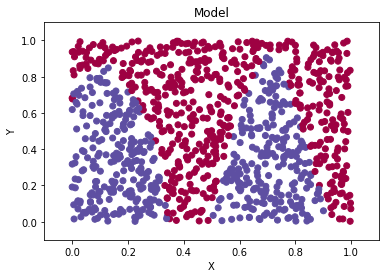

In [13]:
### Model analysis
def predict_dec(X, model):
    # return predictions of X based on provided model
    """
    Original version author: Andrew Ng
    """
    threshold = 0.5
    W, b, activations = model
    L = len(activations)

    A, Z = forward_propagation(X, W, b, activations)
    predictions = (A[L] > threshold)
    return predictions

def plot_decision_dots(X, Y, Y_):
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.scatter(X[0, :], X[1, :], c=Y_.astype(int), cmap=plt.cm.Spectral)
    plt.show()

# Plot predictions w/ color (not including boundary)
def plot(X, Y, model):
    plt.title("Model")
    axes = plt.gca()
    axes.set_xlim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1]) 
    plot_decision_dots(X, Y, predict_dec(X, model))

plot(IN, OUT, MODEL)

In [ ]:
### Gradient Checking (Mostly Andrew Ng's code)

# convert to one long vector
def rollout(W, b):
    L = len(W)-1
    rolled = np.reshape(W[1], (-1, 1))                  # flatten this 2D W[][]
    rolled = np.concatenate((rolled, b[1]),axis=0)
    for i in range(2, L+1):
        rolled = np.concatenate((rolled, np.reshape(W[i], (-1, 1)) ),axis=0)
        rolled = np.concatenate((rolled, b[i]),axis=0)
    return rolled

# convert one long vector back to original
def reroll(theta, origW, origb):
    W = np.copy(origW)
    b = np.copy(origb)
    L = len(W)-1
    idx = 0
    for i in range(1, L+1):
        sz = origW[i].shape[0] * origW[i].shape[1]
        W[i] = theta[idx:idx+sz].reshape(origW[i].shape)
        idx += sz

        sz = origb[i].shape[0] * origb[i].shape[1]
        b[i] = theta[idx:idx+sz].reshape(origb[i].shape)
        idx += sz
    return W, b

def gradient_check(model, grads, X, Y, epsilon = 1e-7):    
    # Set-up variables
    W, b, activations = model
    dW, db = grads
    L = len(activations)

    # convert to each to one long vector (see function rollout() above)
    parameters_values = rollout(W, b)
    grad = rollout(dW, db)

    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]
        thetaplus = np.copy(parameters_values)
        thetaplus[i][0] += epsilon
        nWp, nbp = reroll(thetaplus, W, b)
        Ap, Zp = forward_propagation(X, nWp, nbp, activations)
        J_plus[i] = compute_cost(Ap[L], Y)

        
        # Compute J_minus[i]
        thetaminus = np.copy(parameters_values)
        thetaminus[i][0] -= epsilon
        nWm, nbm = reroll(thetaminus, W, b)
        Am, Zm = forward_propagation(X, nWm, nbm, activations)
        J_minus[i] = compute_cost(Am[L], Y)     
        
        # Compute gradapprox[i]  
        gradapprox[i] = (J_plus[i]-J_minus[i])/(2*epsilon)
    
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
    difference = numerator/denominator

    if difference > 1e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

'''
Before checking, please:
- run random initialization for both W and b
- don't update parameters before check (use W, b which generates current dW, db)
'''
gradient_check(MODEL, GRADS, IN, OUT)

In [ ]:



##########      BELOW THIS LINE IS EXPERIMENTAL AREA, THE CODE MAY BE MESSY      ##########


